In [1]:
import os
import sys
from pathlib import Path
module_path = Path('.').absolute().parents[3]
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
    
from capstone.quant.infrastructure.future_data_container import *
from capstone.quant.tradable.future import *
from capstone.quant.tradable.option import *
from capstone.quant.language import dict_of_dict_to_dataframe
from IPython.display import display, Image
from capstone.quant.dates.schedules import *
from capstone.quant.dates.holidays import get_holidays
from capstone.quant.dates.utils import add_business_days
from capstone.quant.infrastructure.option_data_container import OptionDataRequest, CassandraDSPreLoadFromCacheByDay,CassandraDSOnDemandFromCacheByYear,CassandraDSPreLoadFromCacheByYear
from capstone.quant.data.datalake_cassandra import ExpiryFilterByDateOffset
from capstone.quant.infrastructure.equity_data_container import EquityDataRequest, IVolEquityDataSource
from capstone.quant.infrastructure.fx_data_container import FXDataRequest, DatalakeBBGFXDataSource,DatalakeCitiFXDataSource
from capstone.quant.constants.ccy import Ccy
from capstone.quant.infrastructure.fx_pair import FXPair
from capstone.quant.infrastructure.fx_fwd_data_container import FXFwdDataRequest, DatalakeCitiFXFwdDataSource
from capstone.quant.analytics.symbology import option_root_from_ticker
from capstone.quant.backtest.tranche import DailyTranche
from capstone.quant.backtest.functions.stock_options_daily import stock_options_daily
from capstone.quant.backtest.strategies.rolling_fx_forwards import RollingFXForwards, RollingFXForwardsState
from capstone.quant.backtest.strategies.stock_options_daily import OptionEntryEvent
from capstone.quant.backtest.backtester import LocalBacktester
from capstone.quant.tradable.portfolio import Portfolio
from matplotlib import pyplot as plt

# Backtester: Overview

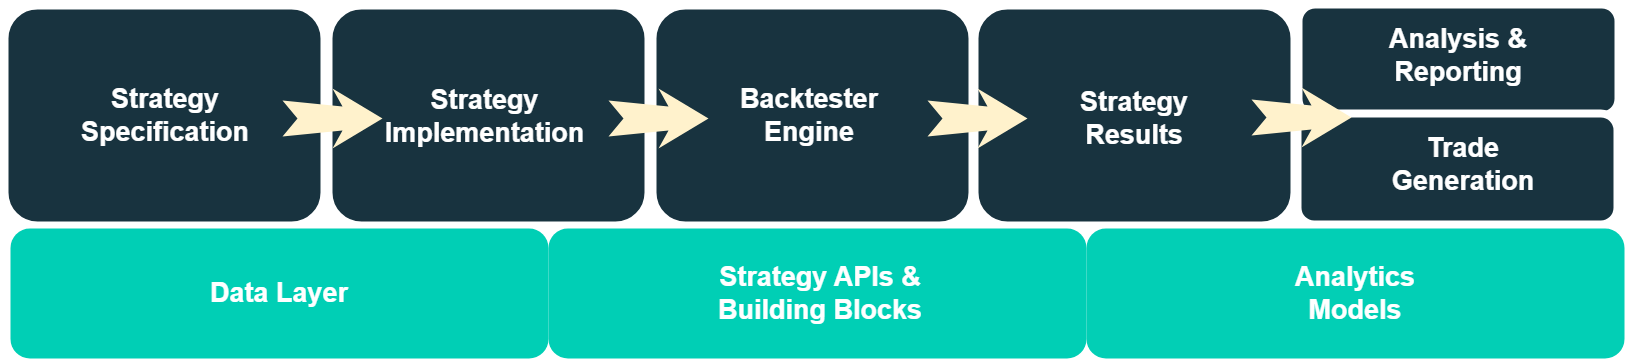

In [2]:
Image(filename='backtester.png', width=1000)

## 1. Getting Data

DataRequests specify what we ask for, independent from where they are from and how they are loaded

DataSet has a set of access functions to get the data corresponding to a DataRequest, again independent from where they are from and how they are loaded

DataSource handles how the data is loaded and where from

Same DataRequest/DataSet may have multiple DataSource

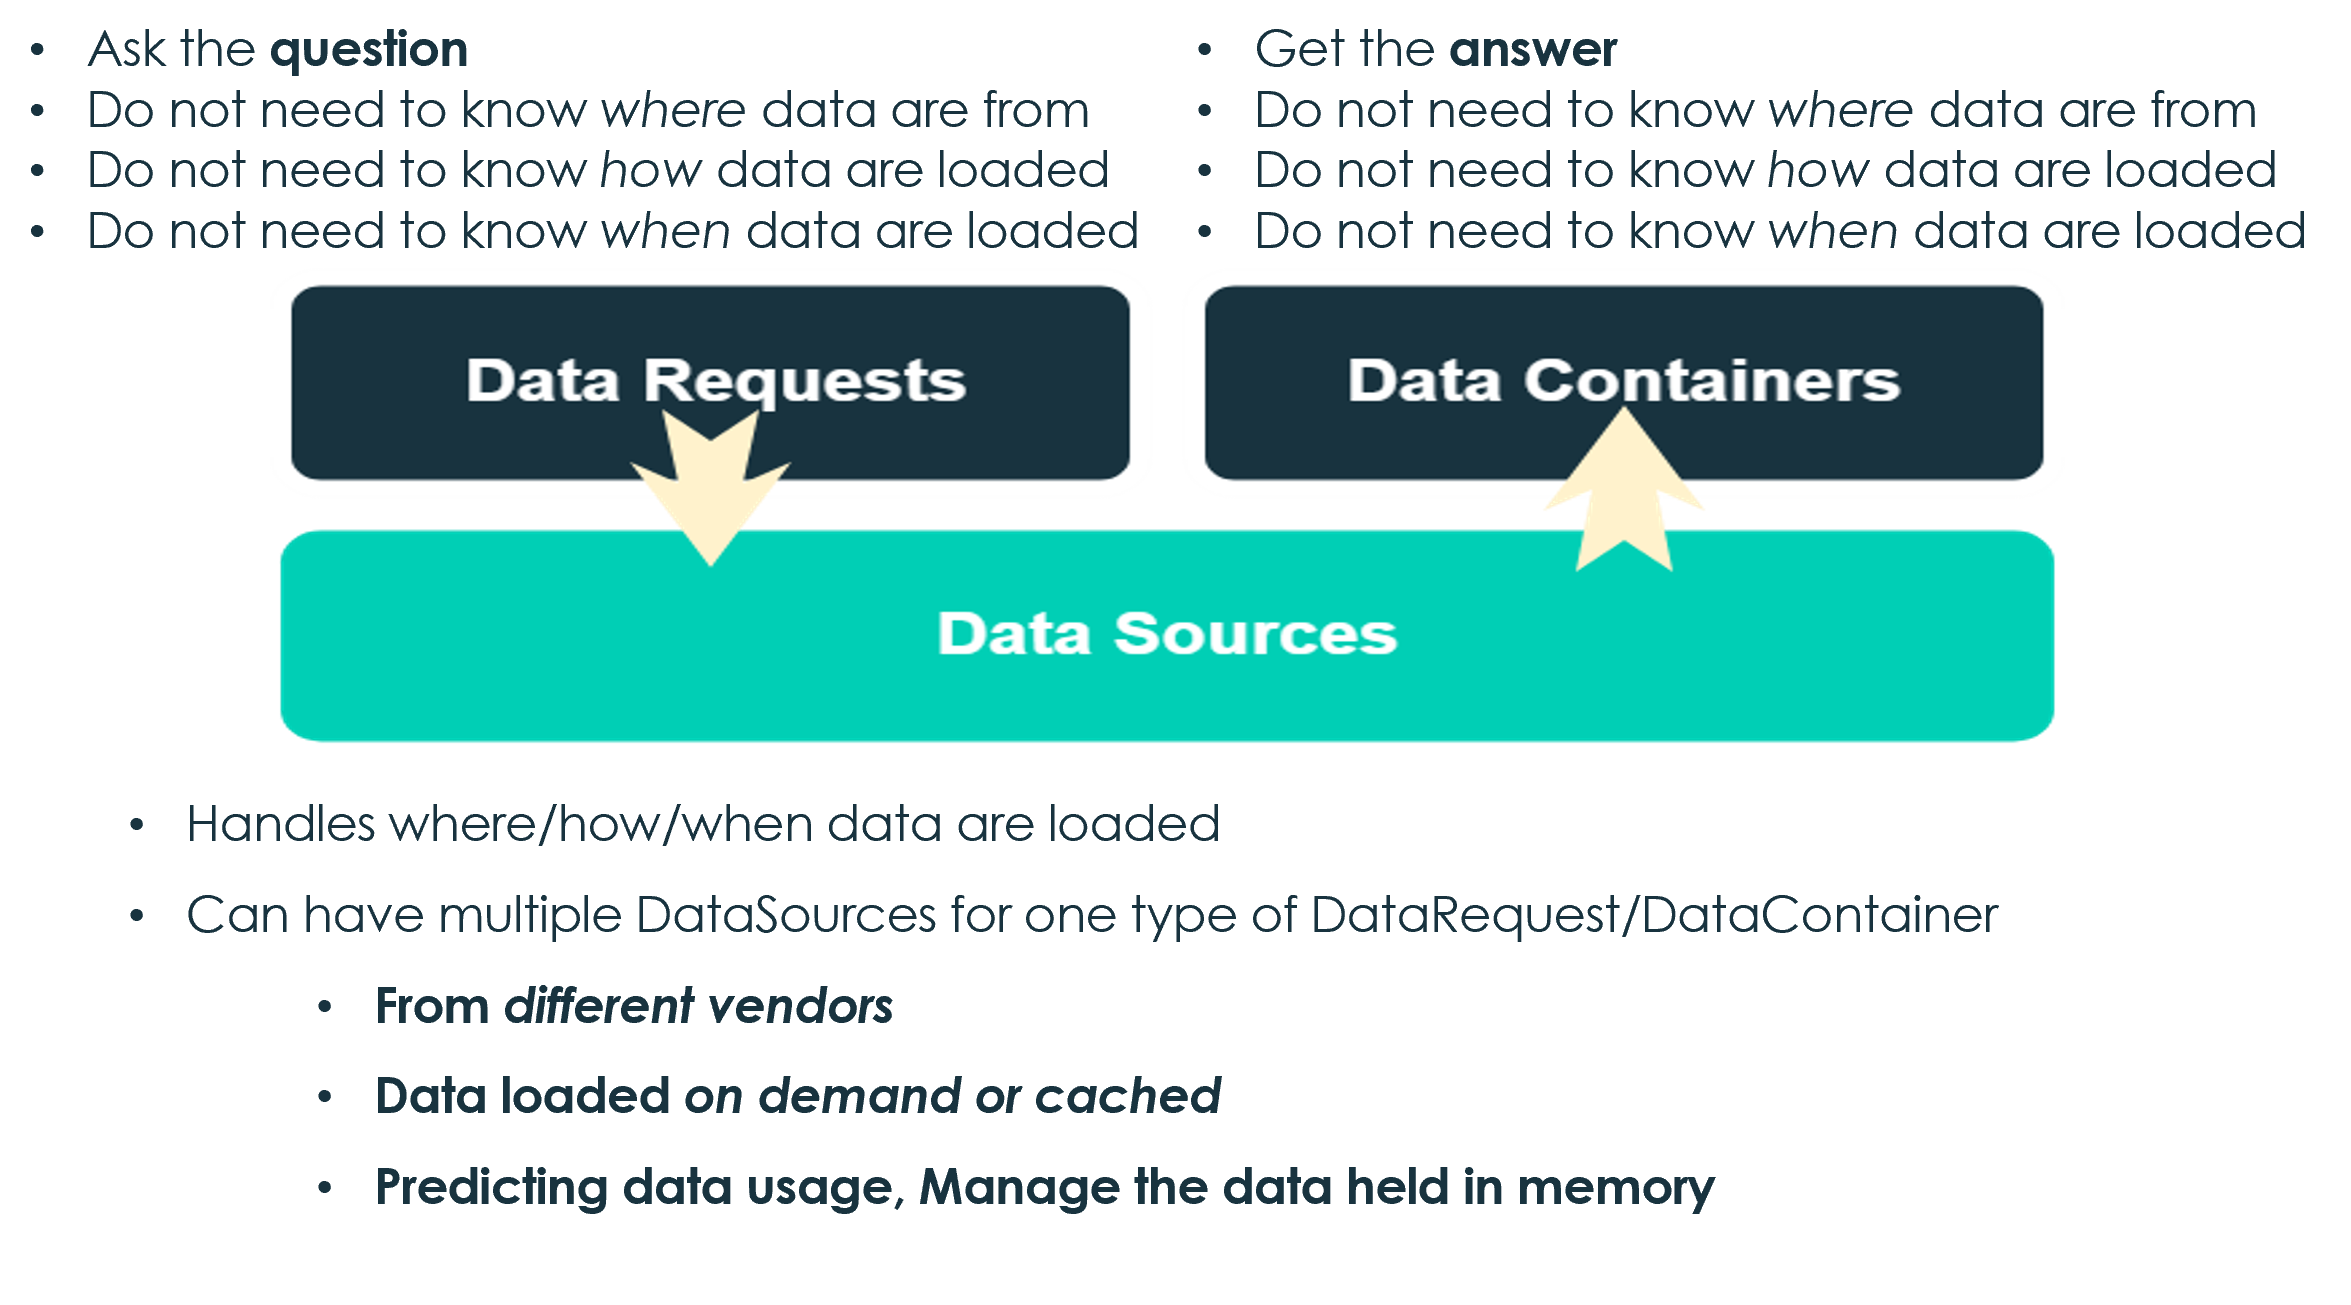

In [3]:
Image(filename='data_model_with_texts.png', width=700)

### Example: Future Data

In [4]:
data_request = FutureDataRequest(datetime(2023, 1, 23), datetime(2023, 1, 24), 'XCME', 'ES', 'Index', expiry_counts=2)
data_source = DatalakeBBGFuturesDataSource()
data_set = data_source.initialize(data_request)

futures = data_set.get_future_universe(datetime(2023, 1, 24), return_as_dict=False)
future_data = data_set.get_future_data(datetime(2023, 1, 24), Future('ES', 'USD', datetime(2023, 3, 17), "CME", "ESH23 Index"), return_as_dict=True)

display(futures)
display(future_data)

,ticker,root,ticker,currency,contract size,month code,last tradable date,exchange
0,ESH23 Index,ES,ESH23 Index,USD,50,H,2023-03-17 00:00:00-05:00,CME
1,ESM23 Index,ES,ESM23 Index,USD,50,M,2023-06-16 00:00:00-05:00,CME


{'close': 4032.75}

### Example: Option Data

### Option data -- Load from Yearly Cache

In [5]:
data_request=OptionDataRequest(datetime(2023, 1, 4),datetime(2023, 1, 8), 'XCBO', 'SPX',ExpiryFilterByDateOffset(100))

data_source=CassandraDSOnDemandFromCacheByYear()

data_set=data_source.initialize(data_request)

In [6]:
options_universe=data_set.get_option_universe(datetime(2023, 1, 4), return_as_dict=False)
options_universe.head()

,expiration,strike,call_put,ask,bid,close,delta,gamma,high,iv,...,vega,volume,expiration_rule,underlying,forward_price,expiration_date,currency,contract_size,tz_name,date
26592452,2023-01-04T00:00:00,1000.0,C,2861.60,2837.6,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,NaN,2023-01-04T00:00:00,USD,1,,2023-01-04T00:00:00
26592453,2023-01-04T00:00:00,1000.0,P,0.05,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,NaN,2023-01-04T00:00:00,USD,1,,2023-01-04T00:00:00
26592454,2023-01-04T00:00:00,1200.0,C,2661.60,2637.6,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,NaN,2023-01-04T00:00:00,USD,1,,2023-01-04T00:00:00
26592455,2023-01-04T00:00:00,1200.0,P,0.05,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,NaN,2023-01-04T00:00:00,USD,1,,2023-01-04T00:00:00
26592456,2023-01-04T00:00:00,1400.0,C,2461.60,2437.6,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,NaN,2023-01-04T00:00:00,USD,1,,2023-01-04T00:00:00


In [7]:
option_to_select=Option('SPX','SPX Index','USD',datetime(2023, 1, 24, 0, 0),1000,True,False,1,None, 'SPX Index2023-01-24T00:00:001000.00000000CallEUSD1')
option=data_set.get_option_data(datetime(2023, 1, 24, 0, 0), option_to_select, return_as_dict=False)
option

,expiration,strike,call_put,ask,bid,close,delta,gamma,high,iv,...,vega,volume,expiration_rule,underlying,forward_price,expiration_date,currency,contract_size,tz_name,date
0,2023-01-24T00:00:00,1000.0,C,3027.3,3003.3,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00


### Option Data -- Load From Daily Cache

In [8]:
data_request=OptionDataRequest(datetime(2023, 1, 23),datetime(2023, 1, 24),['XCBO'], 'SPX',ExpiryFilterByDateOffset(100))

data_source=CassandraDSPreLoadFromCacheByDay()

data_set=data_source.initialize(data_request)

In [9]:
options_universe=data_set.get_option_universe(datetime(2023, 1, 24), return_as_dict=False)
options_universe.head()

,stock_id,expiration,strike,call_put,ask,bid,close,delta,gamma,high,...,vega,volume,expiration_rule,underlying,forward_price,expiration_date,currency,contract_size,tz_name,date
9568,9327,2023-01-24T00:00:00,1000.0,C,3027.30,3003.3,0.0,0.0,0.0,0.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
9569,9327,2023-01-24T00:00:00,1000.0,P,0.05,0.0,0.0,0.0,0.0,0.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
9570,9327,2023-01-24T00:00:00,1200.0,C,2827.30,2803.3,0.0,0.0,0.0,0.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
9571,9327,2023-01-24T00:00:00,1200.0,P,0.05,0.0,0.0,0.0,0.0,0.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
9572,9327,2023-01-24T00:00:00,1400.0,C,2627.30,2603.3,0.0,0.0,0.0,0.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00


### Example for request go beyond cache coverage

In [10]:
%%time

data_request=OptionDataRequest(datetime(2024, 1, 4),datetime(2024, 1, 8),['XCBO'], 'SPX',ExpiryFilterByDateOffset(100))

data_source=CassandraDSOnDemandFromCacheByYear()

data_set=data_source.initialize(data_request)

CPU times: user 76.1 ms, sys: 5.75 ms, total: 81.8 ms
Wall time: 697 ms


In [11]:
options_universe=data_set.get_option_universe(datetime(2024, 1, 4), return_as_dict=False)
options_universe.head()

,stock_id,expiration,strike,call_put,ask,bid,close,delta,gamma,high,...,vega,volume,expiration_rule,underlying,forward_price,expiration_date,currency,contract_size,tz_name,date
33846,9327,2024-01-04T00:00:00,1200.0,C,3499.10,3482.8,3503.60,0.0,0.0,3524.15,...,0.0,6,Weekly's options,SPX Index,4693.22168,2024-01-04T00:00:00,USD,1,,2024-01-04T00:00:00
33847,9327,2024-01-04T00:00:00,1200.0,P,0.05,0.0,0.05,0.0,0.0,0.05,...,0.0,2,Weekly's options,SPX Index,4693.22168,2024-01-04T00:00:00,USD,1,,2024-01-04T00:00:00
33848,9327,2024-01-04T00:00:00,1400.0,C,3299.40,3282.8,0.00,0.0,0.0,0.00,...,0.0,0,Weekly's options,SPX Index,4693.22168,2024-01-04T00:00:00,USD,1,,2024-01-04T00:00:00
33849,9327,2024-01-04T00:00:00,1400.0,P,0.05,0.0,0.00,0.0,0.0,0.00,...,0.0,0,Weekly's options,SPX Index,4693.22168,2024-01-04T00:00:00,USD,1,,2024-01-04T00:00:00
33850,9327,2024-01-04T00:00:00,1600.0,C,3099.40,3082.8,0.00,0.0,0.0,0.00,...,0.0,0,Weekly's options,SPX Index,4693.22168,2024-01-04T00:00:00,USD,1,,2024-01-04T00:00:00


In [12]:
option_to_select=Option('SPX','SPX Index','USD',datetime(2023, 1, 24, 0, 0),1000,True,False,1,None,'SPX Index2023-01-24T00:00:001000.00000000CallEUSD1')
option=data_set.get_option_data(datetime(2023, 1, 24, 0, 0), option_to_select, return_as_dict=False)
display(option)

,expiration,strike,call_put,ask,bid,close,delta,gamma,high,iv,...,vega,volume,expiration_rule,underlying,forward_price,expiration_date,currency,contract_size,tz_name,date
0,2023-01-24T00:00:00,1000.0,C,3027.3,3003.3,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00


### Option data request with preload initialization example

In [13]:
data_request=OptionDataRequest(datetime(2023, 1, 23),datetime(2023, 1, 24),['XCBO'], 'SPX',ExpiryFilterByDateOffset(100))

data_source=CassandraDSPreLoadFromCacheByYear()

data_container=data_source.initialize(data_request)

In [14]:
options_universe=data_container.get_option_universe(datetime(2023, 1, 24), return_as_dict=False)
options_universe.head()

,expiration,strike,call_put,ask,bid,close,delta,gamma,high,iv,...,vega,volume,expiration_rule,underlying,forward_price,expiration_date,currency,contract_size,tz_name,date
26779996,2023-01-24T00:00:00,1000.0,C,3027.30,3003.3,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
26779997,2023-01-24T00:00:00,1000.0,P,0.05,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
26779998,2023-01-24T00:00:00,1200.0,C,2827.30,2803.3,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
26779999,2023-01-24T00:00:00,1200.0,P,0.05,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00
26780000,2023-01-24T00:00:00,1400.0,C,2627.30,2603.3,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00


In [15]:
option_to_select=Option('SPX','SPX Index','USD',datetime(2023, 1, 24, 0, 0),1000,True,False,1,None,'SPX Index2023-01-24T00:00:001000.00000000CallEUSD1')
option=data_container.get_option_data(datetime(2023, 1, 24, 0, 0), option_to_select, return_as_dict=False)
display(option)

,expiration,strike,call_put,ask,bid,close,delta,gamma,high,iv,...,vega,volume,expiration_rule,underlying,forward_price,expiration_date,currency,contract_size,tz_name,date
0,2023-01-24T00:00:00,1000.0,C,3027.3,3003.3,0.0,0.0,0.0,0.0,-1.0,...,0.0,0,Weekly's options,SPX Index,4022.893066,2023-01-24T00:00:00,USD,1,,2023-01-24T00:00:00


## FX data example

In [13]:
#FX spot example
FX_data_request=FXDataRequest(datetime(1990, 1, 1), datetime(2024, 1, 9), ['NYC', 'LON', datetime(2020, 10, 23)], 'USD', 'CAD', fixing_type=None)
FX_spot=DatalakeCitiFXDataSource()
data_set=FX_spot.initialize(FX_data_request)
data_set.get_fx_data(datetime(1990, 1, 1))

{'USDCAD': 1.1585}

In [14]:
#FX forward example
FX_fwd_data_request=FXFwdDataRequest(datetime(1992, 4, 1), datetime(2024, 1, 9), FXPair(Ccy("USD"), Ccy('CAD')))
FX_fwd=DatalakeCitiFXFwdDataSource()
data_set=FX_fwd.initialize(FX_fwd_data_request)
data_set.get_fx_fwd(datetime(2024, 1, 9))

{0.08333333333333333: 1.33966,
 0.019178082191780823: 1.34012,
 1.0: 1.33511,
 0.16666666666666666: 1.33915,
 0.038356164383561646: 1.33999,
 0.25: 1.33864,
 0.5: 1.33738,
 0.75: 1.3363,
 0.0027397260273972603: 1.34027}

## 2. Defining A Strategy

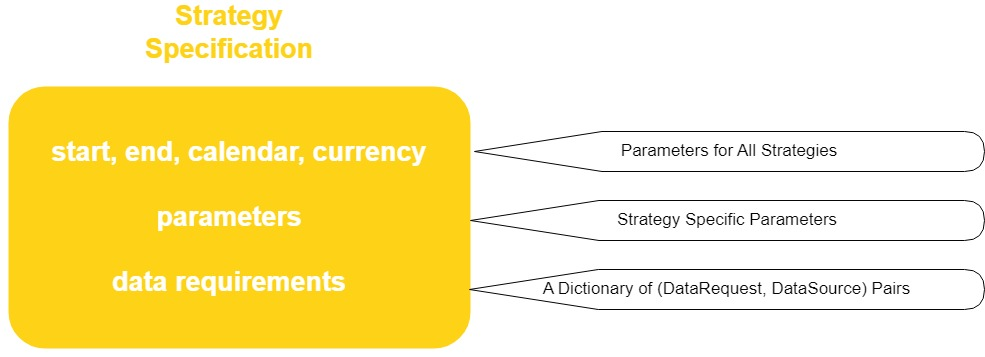

In [15]:
Image(filename='define_a_strategy.jpg', width=700)

### Example: Stock option daily

```python
stock_options_daily_strategy=stock_options_daily(
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    legs={
    'long': {
        'underlying': underlying_long,
        'root': option_root_from_ticker(underlying_long),
        'tenor': tenor,
        'strike': strike,
        'delta': delta,
        'type': call_or_put,
        'other_filters': other_filters,
        'sizing_measure': sizing_measure,
        'sizing_target': sizing_target,
        'tranche': DailyTranche(start_date, end_date, hold_days, bdc, calendar),
        }
    },
    hedged=hedged,
    max_option_expiry_days=100,
    option_data_source=CassandraOnFlyDataSource(),
    allow_fill_forward_missing_data=allow_fill_forward_missing_data,
    use_listed=use_listed,
)
```

## 3. Runing A Backtest

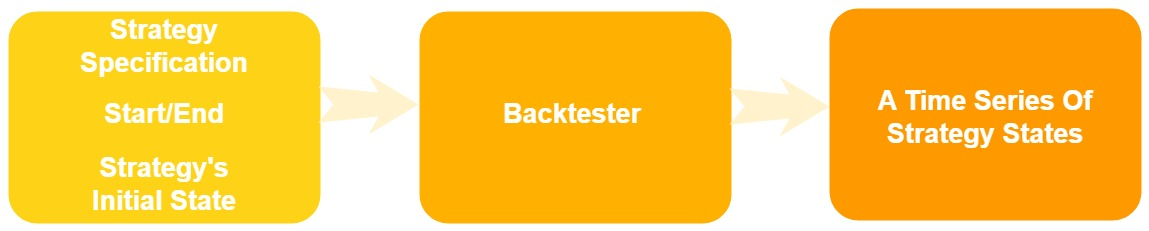

In [16]:
Image(filename='run_a_strategy.jpg', width=700)

### Run Locally

```python
runner = LocalBacktester()
results = runner.run(strategy, start_date, end_date, RollingFXOptionsState(start_date, Portfolio([]), 0.0, 0.0))
```

### Results And StrategyState

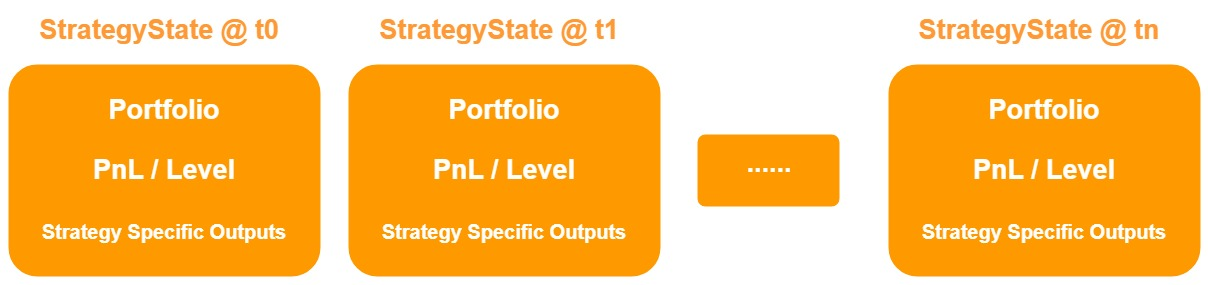

In [17]:
Image(filename='strategy_results.jpg', width=700)

For Example
```python
{
    'cost': 0.0,
    'portfolio': <py3.common.tradable.portfolio.Portfolio object at 0x7f30b62b52b0>,
    'price': 0.5622176396219298,
    'time_stamp': datetime.datetime(2022, 12, 16, 0, 0)
}
```

## 4. Implementing A New Daily Strategy

### Class Structure

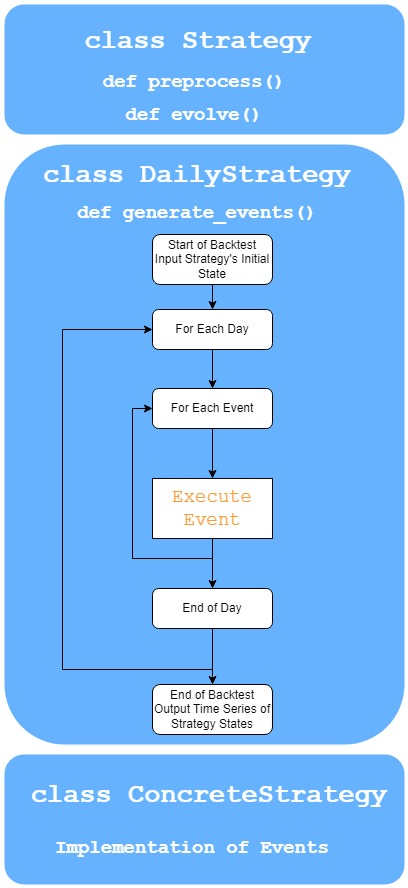

In [18]:
Image(filename='strategy_implementation.jpg', width=350)

### Inheriting From DailyStrategy

```python
class StockOptionsDaily(DailyStrategy):
    def preprocess(self):
        super().preprocess()

        # any specific valuer
        self.valuer_map = self.parameters['valuer_map']

        # how to process corp action
        self.parameters['corpaction_processor'] = CorpActionsProcessor()

        # how to process expiration
        if not 'expires' in self.parameters:
            self.parameters['expires'] = ExpireOptionAtIntrinsic(self.backtest_market)
        elif self.parameters['expires'] == ExpireOptionAtIntrinsic:
            self.parameters['expires'] = ExpireOptionAtIntrinsic(self.backtest_market)
        elif self.parameters['expires'] == ExpireContractsAtPrice:
            self.parameters['expires'] = ExpireContractsAtPrice(self.backtest_market, self.valuer_map)

        # how to charge trading costs
        if 'flat_costs' in self.parameters.keys():
            cost_params = self.parameters[ 'flat_costs' ]
            self.parameters['trading_cost'] = FlatTradingCost( cost_params['tc_delta'], cost_params['tc_vega'] )
        elif 'flat_vega_charge' in self.parameters.keys():
            cost_params = self.parameters[ 'flat_vega_charge']
            self.parameters['trading_cost'] = FlatVegaCostStock( cost_params['tc_delta'], cost_params['tc_vega'] )
        elif 'bid_offer_charge' in self.parameters.keys():
            cost_params = self.parameters[ 'bid_offer_charge' ]
            self.parameters['trading_cost'] = BidOfferCost(cost_params['tc_delta'], cost_params['tc_vega'])

    def generate_events(self, dt: datetime):
        if self.parameters.get('process_dividends_and_corpactions', True):
            return [CorpActionEvent(dt, self), ExpirationEvent(dt, self), OptionEntryEvent(dt, self), OptionDeltaHedgeEvent(dt, self)]
        else:
            return [ExpirationEvent(dt, self), OptionEntryEvent(dt, self), OptionDeltaHedgeEvent(dt, self)]
```

### Inheriting From StrategyState

```python
class StockOptionsDailyState(StrategyState):
    def __init__(self, time_stamp, portfolio, price, cost, portfolio_before_trades=None):
        self.price = price
        self.cost = cost
        self.portfolio_before_trades = portfolio_before_trades
        super().__init__(time_stamp, portfolio)
```

### Defining Events

```python
class OptionEntryEvent(Event):
    def execute(self, state: StrategyState):
        # copy the starting portfolio
        portfolio = state.portfolio.clone()

        ...
        
        return StockOptionsDailyState(self.time_stamp, portfolio, px, 0.0, portfolio_before_trades)
```

## 5. Implementing A New Daily Strategy -- Building Blocks

### Portfolio, Position And Tradable

Portfolio represents a tree of Positions

Position represents a quantity on a Tradable

Tradable represents a tradable contract

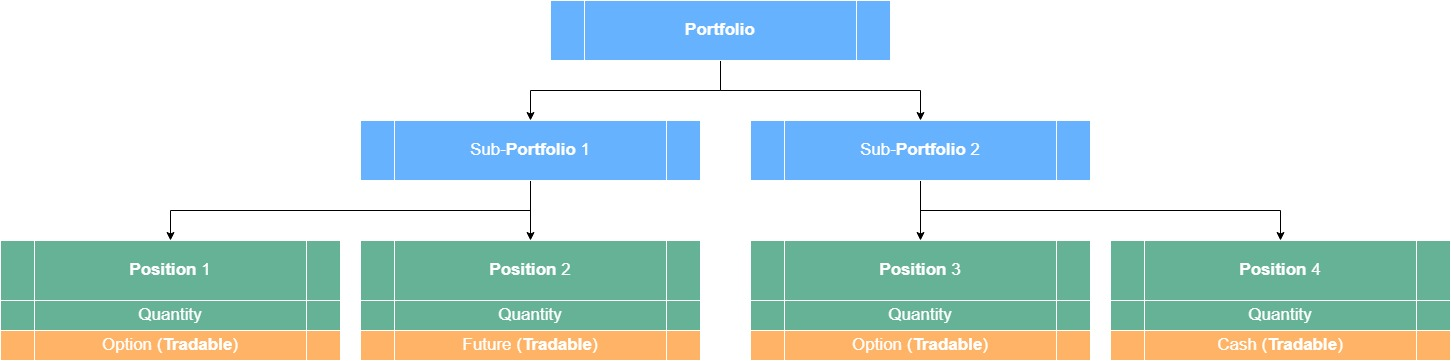

In [19]:
Image(filename='portfolio.jpg', width=1300)

Portfolio APIs
```python
def trade(self, tradable_to_trade, quantity_to_trade, execution_price, execution_currency=None, position_path=(), cash_path=None)
def unwind(self, position_name, unwind_price, unwind_currency=None, cash_path=None)
def price(self, value_func, field, **kwargs)
def price_at_market(self, market, fields, valuer_map_override={}, currency=None, default=None, **kwargs):

def add_position(self, tradable_to_trade: ITradable, quantity_to_trade, position_path=())
def get_position(self, name)
def net_positions(self)
def value_positions(self, value_func)
def aggregate(self, field)
```

### Valuator

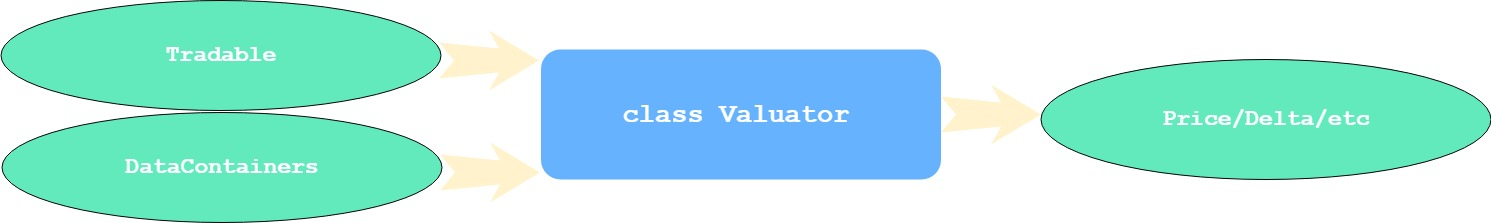

In [20]:
Image(filename='valuator.jpg', width=1000)

```python
(swaption_price, forward_rate, delta_pct) = SwaptionNormValuer().price(swaption=tradable,market=Market(base_datetime=self.time_stamp, vol_cube, atmf_yields, spot_rates, df_curves), calc_types=['price', 'forward_rate', "delta"])
```

### Rolling Contracts

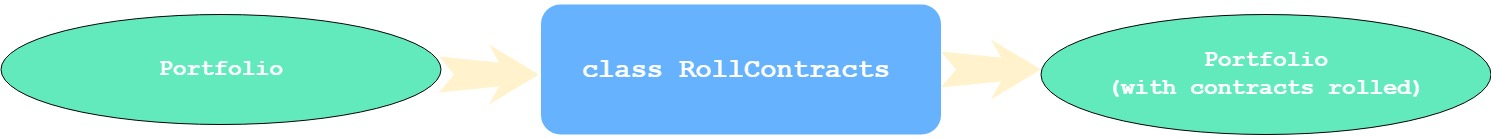

In [21]:
Image(filename='roll.jpg', width=1000)

In preprocess
```python
self.parameters['roll'] = RollFutureContracts(future_ref_dict, future_price_dict, 'close', self.parameters['roll_offset'], 'last tradable date', self.holidays)
```
In evolution
```python
self.parameters['roll'].roll(self.time_stamp, portfolio)
```

### Expiring Contracts

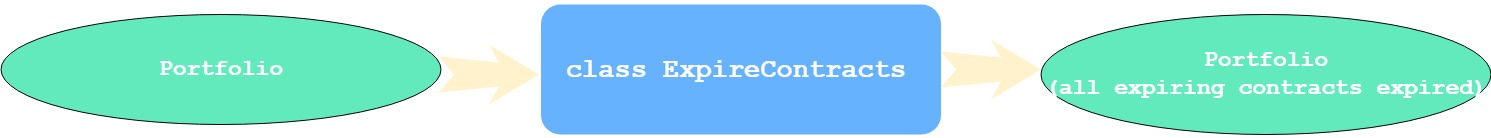

In [22]:
Image(filename='expire.jpg', width=1000)

In preprocess
```python
self.parameters['expires'] = ExpireFXOptionContracts(self.data_containers['spot'], self.data_containers['vol'], self.data_containers['df_curve'])
```
In evolution
```python
self.parameters['expires'].expire(self.time_stamp, portfolio)
```

### Costs

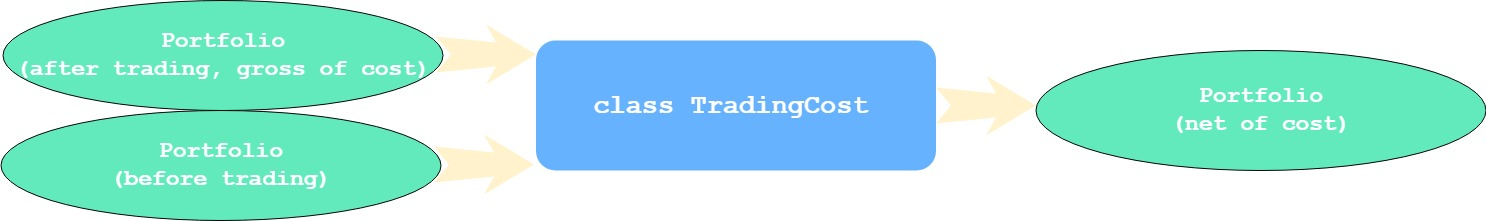

In [23]:
Image(filename='cost.jpg', width=1000)

In preprocess
```python
self.parameters['trading_cost'] = FlatTradingCost(self.parameters['tc_rate'])
```
In evolution
```python
self.parameters['trading_cost'].apply(portfolio, pre_trade_portfolio)
```

### Calendar And Schedule

In [24]:
cme_holidays = get_holidays('XCME', datetime(2022,1,1), datetime(2023,1,1))
cme_holidays

[datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 1, 17, 0, 0),
 datetime.datetime(2022, 2, 21, 0, 0),
 datetime.datetime(2022, 4, 15, 0, 0),
 datetime.datetime(2022, 5, 30, 0, 0),
 datetime.datetime(2022, 6, 20, 0, 0),
 datetime.datetime(2022, 7, 4, 0, 0),
 datetime.datetime(2022, 9, 5, 0, 0),
 datetime.datetime(2022, 11, 24, 0, 0),
 datetime.datetime(2022, 12, 26, 0, 0)]

In [25]:
MonthDaySchedule(15, 'following', cme_holidays).schedule_days(datetime(2022,1,1), datetime(2023,1,1))

[datetime.datetime(2022, 1, 18, 0, 0),
 datetime.datetime(2022, 2, 15, 0, 0),
 datetime.datetime(2022, 3, 15, 0, 0),
 datetime.datetime(2022, 4, 18, 0, 0),
 datetime.datetime(2022, 5, 16, 0, 0),
 datetime.datetime(2022, 6, 15, 0, 0),
 datetime.datetime(2022, 7, 15, 0, 0),
 datetime.datetime(2022, 8, 15, 0, 0),
 datetime.datetime(2022, 9, 15, 0, 0),
 datetime.datetime(2022, 10, 17, 0, 0),
 datetime.datetime(2022, 11, 15, 0, 0),
 datetime.datetime(2022, 12, 15, 0, 0)]

## 6. Analysis And Reporting

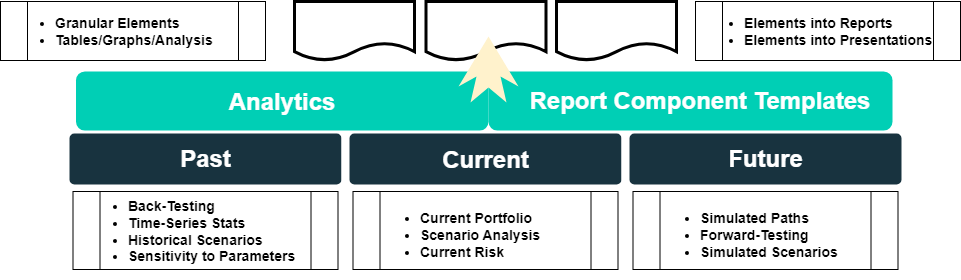

In [26]:
Image(filename='analysis.png', width=700)

To Be Continued

## 7. Evolution

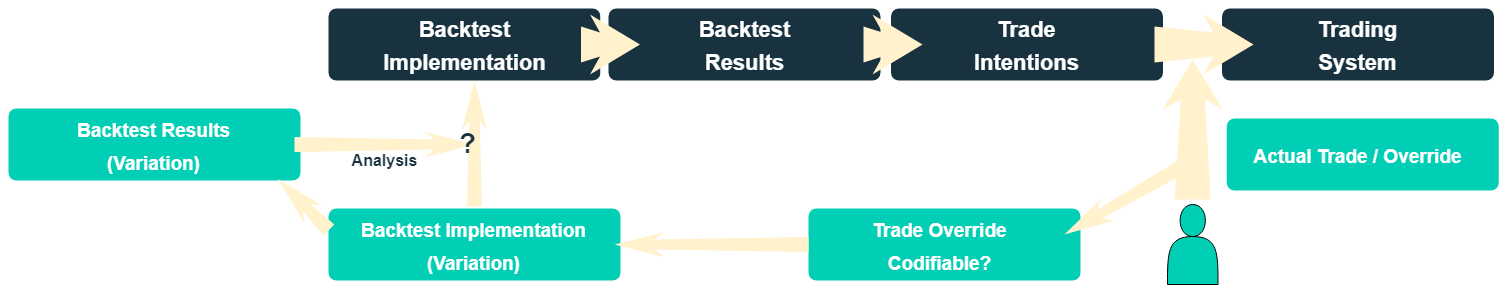

In [27]:
Image(filename='evolution.png', width=800)

## 8. Examples

### Stock option Daily example

In [28]:
# base parameters

start_date = datetime(2012, 1, 3)
start_date = datetime(2022, 1, 3)
end_date = datetime(2023, 12, 14)
calendar = ['XCBO']
underlying = 'SPX Index'

In [3]:
# use listed option or OTC

use_listed = True

if use_listed:
    option_data_source = CassandraDSOnDemandFromCacheByYear()
else:
    option_data_source = VolaEqVolDataSource()
    
# delta hedge or not

hedged = True

#### By Specifying Selection and Sizing Parameters

In [7]:
# rules using parameters

legs = {
    'short_put': {
        'underlying': underlying,
        'tenor': '22D',
        'delta': -0.25,
        'type': 'P',
        'other_filters': [lambda x: x[x['price'] >= 0.05]],
        'sizing_measure': 'notional',
        'sizing_target': -100 / 4,
        'tranche': DailyTranche(start_date, end_date, 20, 'previous', calendar),
    },
    'short_call': {
        'underlying': underlying,
        'tenor': '1M',
        'delta': 0.25,
        'type': 'C',
        'other_filters': [lambda x: x[x['price'] >= 0.05]],
        'sizing_measure': 'notional',
        'sizing_target': -100 / 4,
        'tranche': DailyTranche(start_date, end_date, 20, 'previous', calendar),
    },
}
extra_data_requests = {}

#### By Plug In A Customized Function

In [12]:
# rules using option selection function

def option_selection_function(strategy, strategy_state):
    straddle = [OptionEntryEvent.option_selection_simple(
        strategy, strategy_state,
        underlying,
        use_listed,
        _t,
        'delta', (0.25 if _t=='C' else -0.25),
        '1M',
        other_filters=[lambda x: x[x['price'] >= 0.05]],
    )[0] for _t in ['P', 'C']]
    return straddle

def option_sizing_function(strategy, strategy_state, options_to_trade):
    straddle_sizing = [OptionEntryEvent.option_sizing_simple(
        strategy, strategy_state, [x],
        'notional', -100 / 4)[0] for x in options_to_trade]
    return straddle_sizing
    
legs = {
    'straddle': {
        'underlying': underlying,
        'tranche': DailyTranche(start_date, end_date, 20, 'previous', calendar),
        'option_selection_function': option_selection_function,
        'option_sizing_function': option_sizing_function,
    },
}
extra_data_requests = {}

In [18]:
# rules using customized option selection function
# with extra data

def option_selection_function(strategy, strategy_state):
    straddle = [OptionEntryEvent.option_selection_simple(
        strategy, strategy_state,
        underlying,
        use_listed,
        _t,
        'delta', (0.25 if _t=='C' else -0.25),
        '1M',
        other_filters=[lambda x: x[x['price'] >= 0.05]],
    )[0] for _t in ['P', 'C']]
    return straddle

def option_sizing_function(strategy, strategy_state, options_to_trade):
    straddle_sizing = [OptionEntryEvent.option_sizing_simple(
        strategy, strategy_state, [x],
        'notional', -100 / 4)[0] for x in options_to_trade]
    
    # conditional on other parameters
    time_stamp = strategy_state.time_stamp
    market_tm1 = strategy.backtest_market.get_market(add_business_days(time_stamp, -1, strategy.holidays))
    vix_spot = market_tm1.get_spot('VIX Index')
    adjusted_straddle_sizing = []
    for u, e in straddle_sizing:
        if vix_spot >= 20:
            adjusted_straddle_sizing.append(0)
        else:
            adjusted_straddle_sizing.append(u)
            
    return adjusted_straddle_sizing
    
legs = {
    'straddle': {
        'underlying': underlying,
        'tranche': DailyTranche(start_date, end_date, 20, 'previous', calendar),
        'option_selection_function': option_selection_function,
        'option_sizing_function': option_sizing_function,
    },
}

vix_start_date = add_business_days(start_date, -100)
extra_data_requests = {
    'vix_spot': (EquityDataRequest(vix_start_date, end_date, calendar, 'VIX Index'), IVolEquityDataSource()),
}

#### Results

In [5]:
# run simulation
results, nav_series, portfolio_expanded = stock_options_daily(
    start_date, end_date, calendar, legs, hedged=hedged, max_option_expiry_days=100,
    option_data_source=option_data_source,
    extra_data_requests=extra_data_requests,
    use_listed=use_listed,
)

711it [00:42, 16.88it/s]


In [18]:
results[100].portfolio.root['short_put'].root

{'USDCash': <shared.tradable.position.ValuedPosition at 0x7f280a590d90>,
 'USDConstant': <shared.tradable.position.ValuedPosition at 0x7f280a590f70>,
 'ESM22 Index': <shared.tradable.position.ValuedPosition at 0x7f280a5b9dc0>,
 '2022-04-29_2022-05-27': <shared.tradable.portfolio.Portfolio at 0x7f280a59c1c0>,
 '2022-05-02_2022-05-31': <shared.tradable.portfolio.Portfolio at 0x7f280a59c5b0>,
 '2022-05-03_2022-06-01': <shared.tradable.portfolio.Portfolio at 0x7f280a59c0a0>,
 '2022-05-04_2022-06-02': <shared.tradable.portfolio.Portfolio at 0x7f280a59c730>,
 '2022-05-05_2022-06-03': <shared.tradable.portfolio.Portfolio at 0x7f280a59c7c0>,
 '2022-05-06_2022-06-06': <shared.tradable.portfolio.Portfolio at 0x7f280a59c970>,
 '2022-05-09_2022-06-07': <shared.tradable.portfolio.Portfolio at 0x7f280a59ca60>,
 '2022-05-10_2022-06-08': <shared.tradable.portfolio.Portfolio at 0x7f280a59cb80>,
 '2022-05-11_2022-06-09': <shared.tradable.portfolio.Portfolio at 0x7f280a59cbe0>,
 '2022-05-12_2022-06-10': 

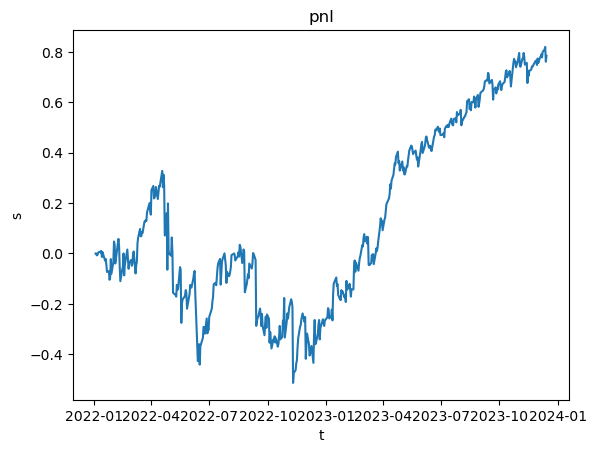

In [6]:
# extract and plot pnl

t = nav_series['date'].values
s = nav_series['pnl'].values

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='t', ylabel='s', title='pnl')
plt.show()

In [21]:
portfolio_expanded.head()

,date,position,quantity,price
0,2022-01-03,SPX Index2022-02-04T00:00:004640.00000000PutEUSD1,-2.606034e-04,35.45
1,2022-01-03,SPX Index2022-02-04T00:00:004895.00000000CallE...,-2.606034e-04,22.00
2,2022-01-03,USDCash,1.497167e-02,1.00
3,2022-01-03,ESH22 Index,9.715838e-07,4786.00
4,2022-01-04,SPX Index2022-02-04T00:00:004640.00000000PutEUSD1,-5.213710e-04,35.95


### FX foward example

#### Simple run 

/home/ychen/ychen_repo/shared/data/Datalake3.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return ret.append(self.getData(source, ticker, fields, mid_plus_1_sec, end))
11690it [00:05, 2112.59it/s]


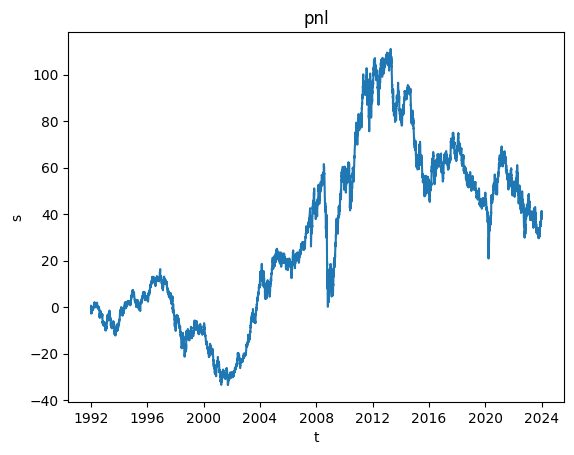

In [39]:
start_date = datetime(1992, 1, 3)
end_date = datetime(2024, 1, 4)
calendar = ['XCBO', datetime(2020, 10, 23)]
pair = 'AUDUSD'
rolling_strategies = []

currency = pair[-3:]
underlying = pair[:3]

# define instance of a strategy
strategy = RollingFXForwards(
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    currency=currency,
    parameters={
        'underlying': underlying,
        'currency': currency,
        'notional': 100,
        'roll_offset': 5,
        'tc_rate': 0.0002,
    },
    data_requests={
        'fx_spot': (
            FXDataRequest(start_date, end_date, calendar, underlying, currency, fixing_type='L160'),
            DatalakeCitiFXDataSource()
        ),
        'fx_forward': (
            FXFwdDataRequest(start_date, end_date, FXPair(Ccy(underlying), Ccy(currency))),
            DatalakeCitiFXFwdDataSource()
        ),
    }

)
# run backtest
runner = LocalBacktester()
results = runner.run(strategy, start_date, end_date, RollingFXForwardsState(start_date, Portfolio([]), 0.0, 0.0))

rolling_strategies.append({'pair': pair, 'strategy': strategy, 'results': results})

records = [{'date': x.time_stamp, 'pnl': x.price} for x in results]
pnl_series = pd.DataFrame.from_dict(records)

expand_ptf = False
if expand_ptf:
    portfolio_expanded = []
    for state in results:
        for k, v in state.portfolio.net_positions().items():
            if not isinstance(v.tradable, Constant):
                portfolio_expanded.append({
                    'date': state.time_stamp,
                    'position': k,
                    'quantity': v.quantity,
                    'price': v.price
                })
    portfolio_expanded = pd.DataFrame.from_records(portfolio_expanded)

#plots
t = pnl_series['date'].values
s = pnl_series['pnl'].values
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set(xlabel='t', ylabel='s', title='pnl')
plt.show()

#### Basket

In [3]:
from shared.backtest.strategies.rolling_fx_forwards_basket import RollingFXForwardsBasket, RollingFXForwardsBasketState

#### user pre defined portfolio

In [4]:
pairs = [
'AUDUSD',
'USDCAD',
'EURUSD',
'USDJPY',
'USDNOK',
'NZDUSD',
'USDSGD',
'USDSEK',
'USDCHF',
'GBPUSD'
]

In [5]:
pre_defined_weights=pd.DataFrame(index=pd.date_range(datetime(1999, 1, 5),datetime(2023, 3, 8)),columns=pairs)

In [6]:
import numpy as np
for index in pre_defined_weights.index:
    
    tmp=np.random.uniform(0,1,10)
    pre_defined_weights.loc[index]=tmp

In [7]:
pre_defined_weights

,AUDUSD,USDCAD,EURUSD,USDJPY,USDNOK,NZDUSD,USDSGD,USDSEK,USDCHF,GBPUSD
1999-01-05,0.981968,0.300164,0.941861,0.910925,0.174873,0.136664,0.91962,0.02488,0.030927,0.511051
1999-01-06,0.015167,0.916117,0.060056,0.337385,0.904947,0.826881,0.641691,0.286034,0.741967,0.24956
1999-01-07,0.656004,0.603539,0.168442,0.166323,0.829975,0.759582,0.471213,0.362507,0.686775,0.116958
1999-01-08,0.444108,0.438095,0.70833,0.866788,0.812976,0.494997,0.400527,0.722394,0.288548,0.967757
1999-01-09,0.22946,0.757161,0.390589,0.758262,0.586317,0.37719,0.786347,0.559466,0.290356,0.126124
...,...,...,...,...,...,...,...,...,...,...
2023-03-04,0.572187,0.492514,0.166763,0.267205,0.731459,0.507951,0.444306,0.092681,0.361424,0.11888
2023-03-05,0.843294,0.001897,0.66699,0.486192,0.201867,0.97582,0.379729,0.093201,0.594964,0.919802
2023-03-06,0.648638,0.233512,0.201997,0.251566,0.240064,0.443684,0.006284,0.229648,0.533121,0.870973
2023-03-07,0.558749,0.406439,0.046599,0.424255,0.119656,0.616233,0.983305,0.138057,0.505919,0.098253


367it [00:02, 164.93it/s]


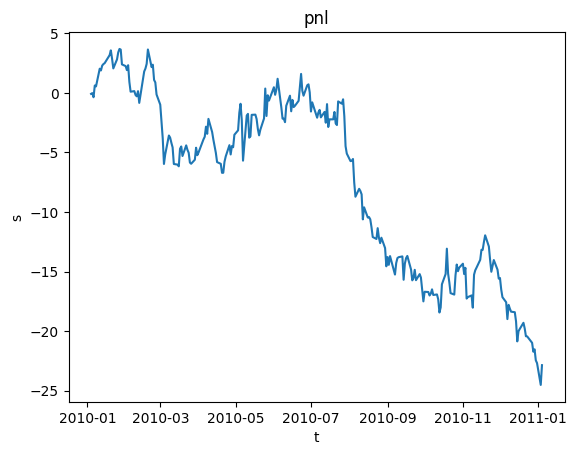

In [14]:
start_date = datetime(2010, 1, 3)
end_date = datetime(2011, 1, 4)
calendar = ['XCBO', datetime(2020, 10, 23)]

data_requests={}

for pair in pairs:
    
    data_requests[pair+'_spot']=(FXDataRequest(start_date, end_date, calendar, pair[:3], pair[-3:], fixing_type='L160'),
        DatalakeCitiFXDataSource())
    data_requests[pair+'_forward']=(
        FXFwdDataRequest(start_date, end_date, FXPair(Ccy(pair[:3]), Ccy(pair[-3:]))),
        DatalakeCitiFXFwdDataSource())


strategy = RollingFXForwardsBasket(
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    currency='USD',
    parameters={
        'legs':{pair:{'underlying': pair[:3],
                        'currency': pair[-3:]}
                for pair in pairs
            },
        'notional': 100,
        'notional_type':'fixed',
        'weights_method': ('Pre_defined',pre_defined_weights),
        'rebalance_schedule': 'daily',
        'roll_offset': 5,
        'tc_rate': 0.0002,
    },
    data_requests=data_requests

)
# run backtest
runner = LocalBacktester()
results = runner.run(strategy, start_date, end_date, RollingFXForwardsBasketState(start_date, Portfolio([]), 0.0, 0.0,100,{},{}))

records = [{'date': x.time_stamp, 'pnl': x.price} for x in results]
pnl_series = pd.DataFrame.from_dict(records)

#plots
t = pnl_series['date'].values
s = pnl_series['pnl'].values
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set(xlabel='t', ylabel='s', title='pnl')
plt.show()

#### simple customized weight

1097it [00:21, 51.84it/s]


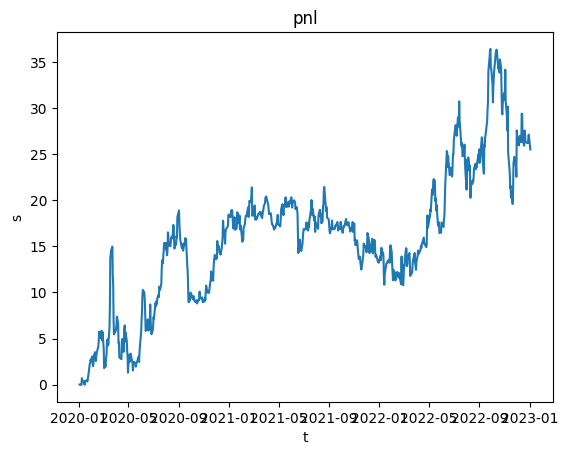

In [55]:
def quick_ewma(strategy,state):
    

    price_df=pd.DataFrame(state.price_hist).T
    
    if len(price_df) > 0:
    
        ll=price_df.ewm(24).mean()
        sl=price_df.ewm(8).mean()

        x=(sl-ll).iloc[-1,:]


        longs=x[x > 0].sort_values(ascending=False).iloc[:3]

        shorts=x[x < 0].sort_values(ascending=True).iloc[:3]

        w = {}

        for index in longs.index:

            w[index] = 1/len(longs.index)

        for index in shorts.index:

            w[index] = -1/len(shorts.index)

        for leg in strategy.parameters['legs'].keys():

            if leg not in w.keys():

                w[leg] = 0
    else:
        
        w = {}

        for leg in strategy.parameters['legs'].keys(): 

            w[leg] = 0
    
    return w
    
    
    

strategy = RollingFXForwardsBasket(
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    currency=currency,
    parameters={
        'legs':{pair:{'underlying': pair[:3],
                        'currency': pair[-3:]}
                for pair in pairs
            },
        'notional': 100,
        'notional_type':'fixed',
        'weight_function': quick_ewma,
        'rebalance_schedule': 'daily',
        'roll_offset': 5,
        'tc_rate': 0.0002,
    },
    data_requests=data_requests

)
# run backtest
runner = LocalBacktester()
results = runner.run(strategy, start_date, end_date, RollingFXForwardsBasketState(start_date, Portfolio([]), 0.0, 0.0,100,{},{}))

records = [{'date': x.time_stamp, 'pnl': x.price} for x in results]
pnl_series = pd.DataFrame.from_dict(records)

#plots
t = pnl_series['date'].values
s = pnl_series['pnl'].values
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set(xlabel='t', ylabel='s', title='pnl')
plt.show()